In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

d2l.init_Seed()
device = d2l.get_device()

GPU ready!


In [2]:
config = {
    "n_train": 100,
    "n_test": 100,
    "max_degree": 20,
    "train_degree": 4,
    "batch_size": 10,
    "n_epochs": 60,
    "optimizer": "SGD",
    # "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.01,         # for SGD and Adam
#         'momentum': 0.9,
#         'nesterov':True
    }
}

In [3]:
def poly(x, w):
    max_degree = len(true_w)
    features = x.pow(torch.arange(max_degree))
    for i in range(max_degree):
        features[:, i] /= math.gamma(i + 1)
    # print(features.shape, w.shape)

    return features @ w


def initial(true_w, n_train=100, n_test=100):
    X = torch.randn((n_train + n_test, 1))
    y = poly(X, true_w)
    y += torch.normal(0, 0.2, y.shape)

    return X, y

In [15]:
true_w = torch.zeros(config['max_degree'])
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])
X, y = initial(true_w, n_train=config['n_train'], n_test=config['n_test'])
tr_set = d2l.prep_dataloader(X[:, :config['train_degree']], y, 'train', config['batch_size'])
te_set = d2l.prep_dataloader(X[:, config['train_degree']:], y, 'test', config['batch_size'])
X[:, :config['train_degree']].shape
X.shape

torch.Size([200, 1])

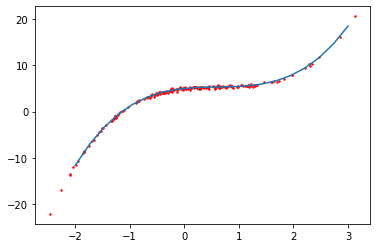

In [5]:
fig, ax = plt.subplots()
ax.scatter(X.numpy(), y.numpy(), c='red', s=2)

x = torch.linspace(-2, 3, 20).reshape(-1, 1)
ax.plot(x.numpy(), poly(x, true_w).numpy())

In [6]:
class MLP(nn.Module):
    def __init__(self, input_degree):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(input_degree, 1, bias=False))
        
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)

        # self.net[0].weight.data.fill_(-1.5)
        # self.net[0].weight.data = torch.tensor([[-1., -1.]])
        self.net.apply(init_weights)


    def forward(self, X):
        return self.net(X).squeeze(1)


In [7]:
def dev_reg(net, dv_set, loss, device='cpu'):
    if isinstance(net, torch.nn.Module):
        net.eval()
    
    metric = torch.zeros(2)

    for X, y in dv_set:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = net(X)
            metric += torch.tensor([loss(y_hat, y).cpu().item() * len(y), y.numel()])

    return float(metric[0] / metric[1])

In [8]:
def train_reg(model, tr_set, te_set, loss, optimizer, lr_scheduler=None, device='cpu', n_epochs=10, early_stop=5):

    epoch = 0

    loss_record = {"train": [], "dev": []}

    animator = d2l.Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0, 1],
                        legend=['train loss', 'test loss'],
                        figsize=(6, 6))
    
    min_loss = 1000.
    
    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            l = loss(model(X), y)
            l.backward()
            optimizer.step()
            
            loss_record['train'].append(l.detach().cpu().item())
        
        if lr_scheduler:
            lr_scheduler.step()
        
        epoch += 1
        
        train_l = dev_reg(model, tr_set, loss, device)
        dev_l = dev_reg(model, tr_set, loss, device)
        
        if dev_l < min_loss:
            min_loss = dev_l
        
        animator.add(epoch, (train_l, dev_l))
        loss_record['dev'].append(dev_l)
#         print(f"epoch: {epoch:3d}, train loss: {train_l: .4f}, dev loss: {dev_l:.4f}")
    
    return min_loss

 ** On entry to SGEMM  parameter number 10 had an illegal value


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

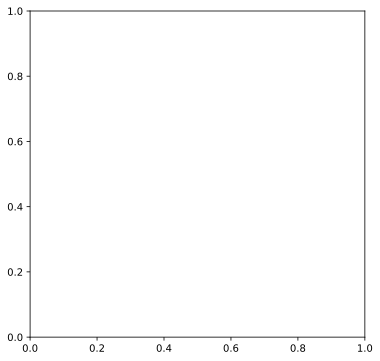

In [9]:
loss = nn.MSELoss(reduction='mean')
model = MLP(input_degree=config['train_degree']).to(device)
optimizer = getattr(torch.optim, config["optimizer"])(
    model.parameters(), **config["optim_hparas"]
)

# lr_scheduler = getattr(torch.optim.lr_scheduler, config["lr_scheduler"])(optimizer, **config["lr_sched_hparas"])

min_loss = train_reg(model, tr_set, te_set, loss, optimizer, None, device, config['n_epochs'])

In [10]:
for X, y in tr_set:
    print(X.shape)
    
    break

torch.Size([10, 1])
